In [1]:
import tensorflow as tf
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall


In [2]:
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
def show_images(original, augmented, labels, title):
    original = original.numpy().transpose((0, 2, 3, 1))
    augmented = augmented.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    original = std * original + mean
    augmented = std * augmented + mean
    original = np.clip(original, 0, 1)
    augmented = np.clip(augmented, 0, 1)
    
    fig, axes = plt.subplots(2, len(original), figsize=(15, 5))
    for i in range(len(original)):
        axes[0, i].imshow(original[i])
        axes[0, i].set_title(labels[i])
        axes[0, i].axis('off')
        axes[1, i].imshow(augmented[i])
        axes[1, i].set_title(labels[i])
        axes[1, i].axis('off')
    plt.suptitle(title)
    plt.show()

def visualize_augmentations(dataloader, dataset_name):
    inputs, classes = next(iter(dataloader))
    indices = random.sample(range(len(inputs)), 5)
    original_images = inputs[indices]
    labels = [class_names[classes[i]] for i in indices]
    
    # Convert tensors to PIL images and apply transformations
    augmented_images = torch.stack([dataloader.dataset.dataset.transform(F.to_pil_image(img)) for img in original_images])
    
    # Show original and augmented images side by side with labels
    show_images(original_images, augmented_images, labels, f'{dataset_name} Set - Original and Augmented Images')

# Visualize augmentations for train, val, and test sets
visualize_augmentations(dataloaders['train'], 'Train')
visualize_augmentations(dataloaders['val'], 'Validation')
visualize_augmentations(dataloaders['test'], 'Test')

NameError: name 'dataloaders' is not defined

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

class SkinCancerModel(nn.Module):
    def __init__(self, num_classes=2):
        super(SkinCancerModel, self).__init__()
        # Load pretrained ResNet50
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        
        # Freeze layers
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Modify final layers
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        return self.model(x)

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=30):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    # For early stopping
    patience = 7
    counter = 0
    best_loss = float('inf')
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.cpu())
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'val':
                scheduler.step(epoch_loss)
                
                # Early stopping
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    counter = 0
                    best_model_wts = model.state_dict()
                    best_acc = epoch_acc
                else:
                    counter += 1
                
        if counter >= patience:
            print("Early stopping triggered")
            break
            
        print()
    
    print(f'Best Val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, history

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(history['train_acc'], label='Train Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def visualize_predictions(model, test_loader, num_images=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    # Get a batch of test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(images.to(device))
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
    
    # Calculate grid dimensions
    num_rows = (num_images + 2) // 3  # 3 images per row
    num_cols = min(3, num_images)
    
    # Plot images
    fig = plt.figure(figsize=(15, 5*num_rows))
    for idx in range(num_images):
        ax = fig.add_subplot(num_rows, num_cols, idx + 1)
        
        # Process and display image
        img = images[idx].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        true_label = 'Benign' if labels[idx] == 0 else 'Malignant'
        pred_label = 'Benign' if preds[idx] == 0 else 'Malignant'
        confidence = probs[idx][preds[idx]].item() * 100
        
        color = 'green' if labels[idx] == preds[idx] else 'red'
        ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%',
                    color=color, pad=10)
        ax.axis('off')
    
    plt.tight_layout(pad=3.0)  # Add padding between subplots
    plt.show()
    
def evaluate_model(model, dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            running_corrects += torch.sum(preds == labels.data)
    
    accuracy = running_corrects.double() / len(dataloader.dataset)
    return accuracy.item()  # Return the accuracy value

# Main training
def main():
    # Initialize model
    model = SkinCancerModel()
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam([
        {'params': model.model.fc.parameters(), 'lr': 1e-3}
    ])
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                   factor=0.1, patience=3, verbose=True)
    
    # Train model
    model, history = train_model(model, dataloaders, criterion, optimizer, 
                               scheduler, num_epochs=30)
    
    # Plot training history
    plot_training_history(history)
    
    # Save model
    torch.save(model.state_dict(), 'skin_cancer_model.pth')
    
    # Test set evaluation
    model.eval()
    test_acc = evaluate_model(model, dataloaders['val'])  # Using val as test for this example
    print(f'Test Accuracy: {test_acc:.4f}')
    
    # Visualize predictions
    visualize_predictions(model, dataloaders['val'])

if __name__ == "__main__":
    main()

In [ ]:
def plot_metric(metric, train_metric, val_metric, epochs=50):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_metric, label=f'Training {metric}', alpha=0.5)
    plt.plot(range(1, epochs + 1), val_metric, label=f'Validation {metric}', alpha=0.5)
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(f'Training and Validation {metric} Over Epochs')
    plt.legend()
    plt.show()

def plot_roc_curve(y_true, y_pred):
    fpr_original, tpr_original, _ = roc_curve(y_true, y_pred)
    roc_auc_original = auc(fpr_original, tpr_original)
    plt.plot(fpr_original, tpr_original, marker=".", label="Neural Network")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.text(0.6, 0.2, f"AUC = {roc_auc_original:.2f}")
    plt.show()

def load_from_dataset(path, img_size_w, img_size_h):
    data = []
    for f in glob.iglob(path):
        img = cv2.imread(f)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(img_size_w,img_size_h))
        data.append(img)
    return data

def tempPlot():
    # Calculate grid dimensions
    num_rows = (num_images + 2) // 3  # 3 images per row
    num_cols = min(3, num_images)
    
    # Plot images
    fig = plt.figure(figsize=(15, 5*num_rows))
    for idx in range(num_images):
        ax = fig.add_subplot(num_rows, num_cols, idx + 1)
        
        # Process and display image
        img = images[idx].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        true_label = 'Benign' if labels[idx] == 0 else 'Malignant'
        pred_label = 'Benign' if preds[idx] == 0 else 'Malignant'
        confidence = probs[idx][preds[idx]].item() * 100
        
        color = 'green' if labels[idx] == preds[idx] else 'red'
        ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%',
                    color=color, pad=10)
        ax.axis('off')
    
    plt.tight_layout(pad=3.0)  # Add padding between subplots
    plt.show()

def count_batches(loader):
    return sum(1 for _ in loader)

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
class SkinCancerModel(nn.Module):
    def __init__(self, num_classes=2):
        super(SkinCancerModel, self).__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        for param in self.model.parameters():
            param.requires_grad = False
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        return self.model(x)

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=30):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    patience = 7
    counter = 0
    best_loss = float('inf')
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.cpu())
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'val':
                scheduler.step(epoch_loss)
                
                # Early stopping
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    counter = 0
                    best_model_wts = model.state_dict()
                    best_acc = epoch_acc
                else:
                    counter += 1
                
        if counter >= patience:
            print("Early stopping triggered")
            break
            
        print()
    
    print(f'Best Val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, history

def visualize_predictions(model, test_loader, num_images=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()

    # Get a batch of test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(images.to(device))
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
    
    # Calculate grid dimensions
    num_rows = (num_images + 2) // 3  # 3 images per row
    num_cols = min(3, num_images)
    
    # Plot images
    fig = plt.figure(figsize=(15, 5*num_rows))
    for idx in range(num_images):
        ax = fig.add_subplot(num_rows, num_cols, idx + 1)
        
        # Process and display image
        img = images[idx].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        true_label = 'Benign' if labels[idx] == 0 else 'Malignant'
        pred_label = 'Benign' if preds[idx] == 0 else 'Malignant'
        confidence = probs[idx][preds[idx]].item() * 100
        
        color = 'green' if labels[idx] == preds[idx] else 'red'
        ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%',
                    color=color, pad=10)
        ax.axis('off')
    
    plt.tight_layout(pad=3.0)  # Add padding between subplots
    plt.show()
    
def evaluate_model(model, dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            running_corrects += torch.sum(preds == labels.data)
    
    accuracy = running_corrects.double() / len(dataloader.dataset)
    return accuracy.item()  # Return the accuracy value

# Main training
def main():
    # Initialize model
    model = SkinCancerModel()
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam([
        {'params': model.model.fc.parameters(), 'lr': 1e-3}
    ])
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                   factor=0.1, patience=3, verbose=True)
    
    # Train model
    model, history = train_model(model, dataloaders, criterion, optimizer, 
                               scheduler, num_epochs=30)
    
    # Plot training history
    plot_training_history(history)
    
    # Save model
    torch.save(model.state_dict(), 'skin_cancer_model.pth')
    
    # Test set evaluation
    model.eval()
    test_acc = evaluate_model(model, dataloaders['val'])  # Using val as test for this example
    print(f'Test Accuracy: {test_acc:.4f}')
    
    # Visualize predictions
    visualize_predictions(model, dataloaders['val'])

if __name__ == "__main__":
    main()

In [2]:
# import torch
# print("PyTorch GPU availability:", torch.cuda.is_available())
# print("Current CUDA device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device")

# import tensorflow as tf
# print("TensorFlow GPU available:", tf.config.list_physical_devices('GPU'))


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# List all available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to avoid OOM errors if GPU memory is not fully utilized
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("TensorFlow is using GPU(s):")
        for gpu in gpus:
            print(" -", gpu.name)
    except RuntimeError as e:
        # Memory growth must be set before GPUs are initialized
        print("Error while setting up GPU memory growth:", e)
else:
    print("No GPUs detected. Ensure CUDA and cuDNN are properly installed.")


Num GPUs Available:  0
No GPUs detected. Ensure CUDA and cuDNN are properly installed.


In [4]:
train_dir = './../data/bean-leaf-dataset/train/train'
validation_dir = './../data/bean-leaf-dataset/validation/validation'
test_dir = './../data/bean-leaf-dataset/test/test'


assert os.path.exists(train_dir), "Training directory not found."
assert os.path.exists(validation_dir), "Validation directory not found."
assert os.path.exists(test_dir), "Test directory not found."


In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history, history_fine): 
    # Combine histories
    combined_acc = history.history['accuracy'] + history_fine.history['accuracy']
    combined_val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
    combined_loss = history.history['loss'] + history_fine.history['loss']
    combined_val_loss = history.history['val_loss'] + history_fine.history['val_loss']
    min_acc = min(min(combined_acc), min(combined_val_acc)) * 100  

    min_acc_tick = int(min_acc - (min_acc % 5))
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(combined_acc, label='Training Accuracy')
    plt.plot(combined_val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.yticks([i / 100 for i in range(min_acc_tick, 101, 5)]) 
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(combined_loss, label='Training Loss')
    plt.plot(combined_val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()



In [ ]:
import matplotlib.pyplot as plt

def plot_training_history2(history): 
    # Combine histories
    combined_acc = history.history['accuracy']
    combined_val_acc = history.history['val_accuracy']
    combined_loss = history.history['loss'] 
    combined_val_loss = history.history['val_loss']
    min_acc = min(min(combined_acc), min(combined_val_acc)) * 100  

    min_acc_tick = int(min_acc - (min_acc % 5))
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(combined_acc, label='Training Accuracy')
    plt.plot(combined_val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.yticks([i / 100 for i in range(min_acc_tick, 101, 5)]) 
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(combined_loss, label='Training Loss')
    plt.plot(combined_val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()



In [ ]:
with tf.device('/gpu:0'):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),  
        batch_size=128,
        shuffle=True,
        class_mode='categorical'
    )
    
    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical'
    )
    
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical'
    )

    base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False


Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.
Found 128 images belonging to 3 classes.
19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
with tf.device('/gpu:0'):
    
    no_scale_train_datagen = ImageDataGenerator(
        #rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    
    no_scale_validation_datagen = ImageDataGenerator()
    
    no_scale_test_datagen = ImageDataGenerator()
    
    no_scale_train_generator = no_scale_train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),  
        batch_size=64,
        shuffle=True,
        class_mode='categorical'
    )
    
    no_scale_validation_generator = no_scale_validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical'
    )
    
    no_scale_test_generator = no_scale_test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical'
    )

    base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False


Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.
Found 128 images belonging to 3 classes.


In [ ]:
def create_optimizer(optimizer, lr=3e-4): 
    if optimizer == 'adam': 
        return Adam(learning_rate=lr)
    elif optimizer == 'nadam': 
        return Nadam(learning_rate=lr) 
    elif optimizer == 'rmsprop': 
        return RMSprop(learning_rate=lr) 
    else: 
        raise ValueError("Unsupported optimizer")

In [ ]:
def train_model(base_model, dense_layers, dense_layers_dropout, train_generator, validation_generator, 
                optimizer, loss, metrics, freezed_epochs, fine_tune_epochs, learning_rate=3e-4):
    base_model.trainable = False  
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    for i in range(len(dense_layers)) :
        x = Dense(dense_layers[i], activation='relu')(x)
        # x = BatchNormalization()(x)
        x = Dropout(dense_layers_dropout[i])(x)
    
    num_classes = train_generator.num_classes
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    
    model.compile(
        optimizer=create_optimizer(optimizer, learning_rate),
        loss=loss,
        metrics=metrics
    )

    # freazed_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss',  
    #     factor=0.5,          
    #     patience=5,          
    #     min_lr=1e-6          
    # )

    early_stopping_freeze = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5, 
        restore_best_weights=True
    )
    
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=freezed_epochs,
        callbacks=[early_stopping_freeze]
    )
    
    base_model.trainable = True
    
    model.compile(
        optimizer=create_optimizer(optimizer, learning_rate),
        loss=loss,
        metrics=metrics
    )

    # finetune_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss',  
    #     factor=0.5,          
    #     patience=10,          
    #     min_lr=1e-6          
    # )

    early_stopping_fine = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,  
        restore_best_weights=True
    )
    
    history_fine = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=fine_tune_epochs,
        callbacks=[early_stopping_fine]
    )

    return model, history, history_fine

In [ ]:
def train_model2(base_model, dense_layers, dense_layers_dropout, train_generator, validation_generator, 
                optimizer, loss, metrics, freezed_epochs, fine_tune_epochs, learning_rate=3e-4):
    base_model.trainable = False  
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    for i in range(len(dense_layers)) :
        x = Dense(dense_layers[i], activation='relu')(x)
        # x = BatchNormalization()(x)
        x = Dropout(dense_layers_dropout[i])(x)
    
    num_classes = train_generator.num_classes
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    
    model.compile(
        optimizer=create_optimizer(optimizer, learning_rate),
        loss=loss,
        metrics=metrics
    )

    # freazed_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss',  
    #     factor=0.5,          
    #     patience=5,          
    #     min_lr=1e-6          
    # )

    early_stopping_freeze = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5, 
        restore_best_weights=True
    )
    
    steps_per_epoch = train_generator.samples // train_generator.batch_size
    validation_steps = validation_generator.samples // validation_generator.batch_size
    
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=freezed_epochs,
        callbacks=[early_stopping_freeze]
    )
    
    base_model.trainable = True
    for layer in base_model.layers[:-(len(base_model.layers)//10)]:  
        layer.trainable = False
    
    model.compile(
        optimizer=create_optimizer(optimizer, learning_rate),
        loss=loss,
        metrics=metrics
    )

    # finetune_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss',  
    #     factor=0.5,          
    #     patience=10,          
    #     min_lr=1e-6          
    # )

    early_stopping_fine = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,  
        restore_best_weights=True
    )
    
    history_fine = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=fine_tune_epochs,
        callbacks=[early_stopping_fine]
    )

    return model, history, history_fine

In [ ]:
with tf.device('/gpu:0'):
    nasNet_base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    nasNet_model, nasNet_history, nasNet_history_fine = train_model(base_model=nasNet_base_model, 
                dense_layers=[256], dense_layers_dropout=[0.5], 
                train_generator=train_generator, validation_generator=validation_generator, 
                optimizer='adam', loss='categorical_crossentropy', 
                metrics=['accuracy', Precision(), Recall()], freezed_epochs=100, fine_tune_epochs=100)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732359991.280373     113 service.cc:145] XLA service 0x7de520004810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732359991.280421     113 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/9 ━━━━━━━━━━━━━━━━━━━━ 6:34 49s/step - accuracy: 0.3984 - loss: 1.2222 - precision: 0.3288 - recall: 0.1875

I0000 00:00:1732360006.485439     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.4205 - loss: 1.1586 - precision: 0.4104 - recall: 0.2603 - val_accuracy: 0.5714 - val_loss: 0.9300 - val_precision: 0.6842 - val_recall: 0.2932
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 442ms/step - accuracy: 0.5132 - loss: 0.9720 - precision: 0.5547 - recall: 0.4048 - val_accuracy: 0.6391 - val_loss: 0.8194 - val_precision: 0.7476 - val_recall: 0.5789
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 427ms/step - accuracy: 0.6346 - loss: 0.8313 - precision: 0.6893 - recall: 0.5572 - val_accuracy: 0.7519 - val_loss: 0.7046 - val_precision: 0.8020 - val_recall: 0.6090
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 427ms/step - accuracy: 0.6757 - loss: 0.7509 - precision: 0.7249 - recall: 0.5954 - val_accuracy: 0.7519 - val_loss: 0.6745 - val_precision: 0.7788 - val_recall: 0.6617
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 435ms/step - accuracy: 0.7105 - loss: 0.6986 - precision: 0.7589 - recall: 0.6328 - val_accuracy: 0.7895 - val_loss: 0.6218 - val_prec

In [ ]:
test_loss, test_accuracy, test_precision, test_recall = nasNet_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}% \nTest recall: {test_recall * 100:.2f}% \nTest precision: {test_precision * 100:.2f}% \n ")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - accuracy: 0.8906 - loss: 0.4611 - precision: 0.8995 - recall: 0.8854
Test Accuracy: 89.06% 
Test recall: 88.28% 
Test precision: 89.68% 
 


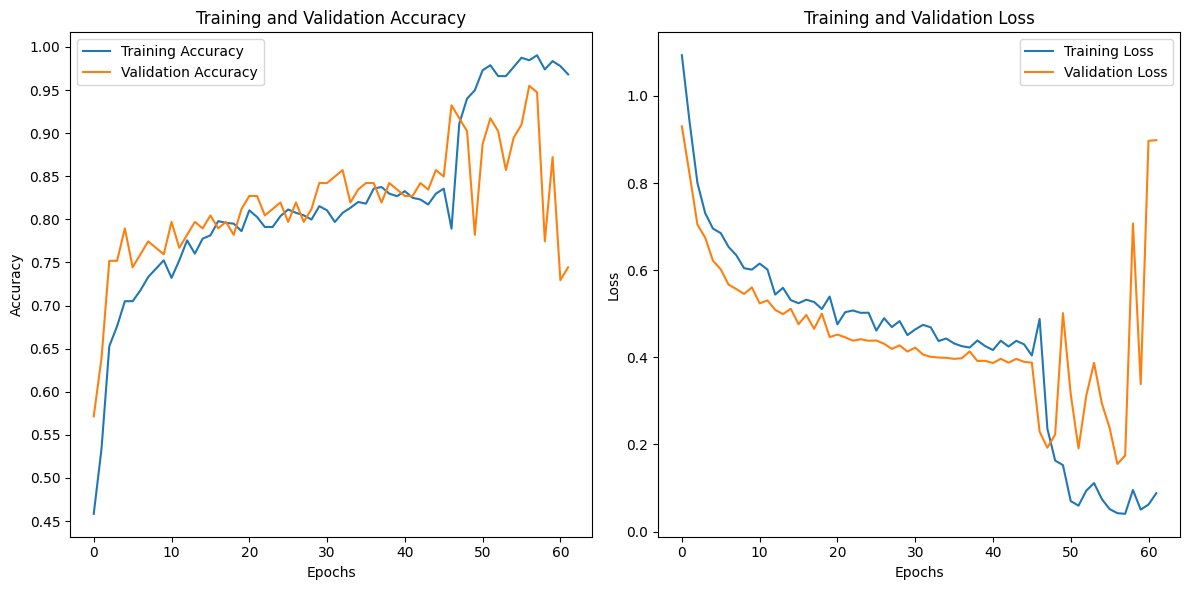

In [ ]:
plot_training_history(nasNet_history, nasNet_history_fine)

In [ ]:
with tf.device('/gpu:0'):
    nasNet_base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    nadam_nasNet_model, nadam_nasNet_history, nadam_nasNet_history_fine = train_model(base_model=
                                                                                      nasNet_base_model, 
                dense_layers=[256], dense_layers_dropout=[0.5], 
                train_generator=train_generator, validation_generator=validation_generator, 
                optimizer='nadam', loss='categorical_crossentropy', 
                metrics=['accuracy', Precision(), Recall()], freezed_epochs=100, fine_tune_epochs=100)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.3750 - loss: 1.2667 - precision_1: 0.3902 - recall_1: 0.2590 - val_accuracy: 0.5113 - val_loss: 0.9570 - val_precision_1: 0.6094 - val_recall_1: 0.2932
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 462ms/step - accuracy: 0.5346 - loss: 0.9815 - precision_1: 0.5962 - recall_1: 0.4193 - val_accuracy: 0.6316 - val_loss: 0.8206 - val_precision_1: 0.7471 - val_recall_1: 0.4887
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 243ms/step - accuracy: 0.6109 - loss: 0.8191 - precision_1: 0.6566 - recall_1: 0.5112 - val_accuracy: 0.6842 - val_loss: 0.7690 - val_precision_1: 0.7526 - val_recall_1: 0.5489
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 472ms/step - accuracy: 0.6438 - loss: 0.7604 - precision_1: 0.6892 - recall_1: 0.5543 - val_accuracy: 0.7143 - val_loss: 0.6902 - val_precision_1: 0.7944 - val_recall_1: 0.6391
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 440ms/step - accuracy: 0.6730 - loss: 0.7328 - precision_1: 0.7372 - recall_1: 0.6135 - va

In [ ]:
nadam_nasNet_test_loss, nadam_nasNet_test_accuracy, nadam_nasNet_test_precision, nadam_nasNet_test_recall = nadam_nasNet_model.evaluate(test_generator)
print(f"Test Accuracy: {nadam_nasNet_test_accuracy * 100:.2f}% \nTest recall: {nadam_nasNet_test_recall * 100:.2f}% \nTest precision: {nadam_nasNet_test_precision * 100:.2f}% \n ")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step - accuracy: 0.9167 - loss: 0.2161 - precision_1: 0.9255 - recall_1: 0.9062
Test Accuracy: 92.19% 
Test recall: 91.41% 
Test precision: 92.86% 
 


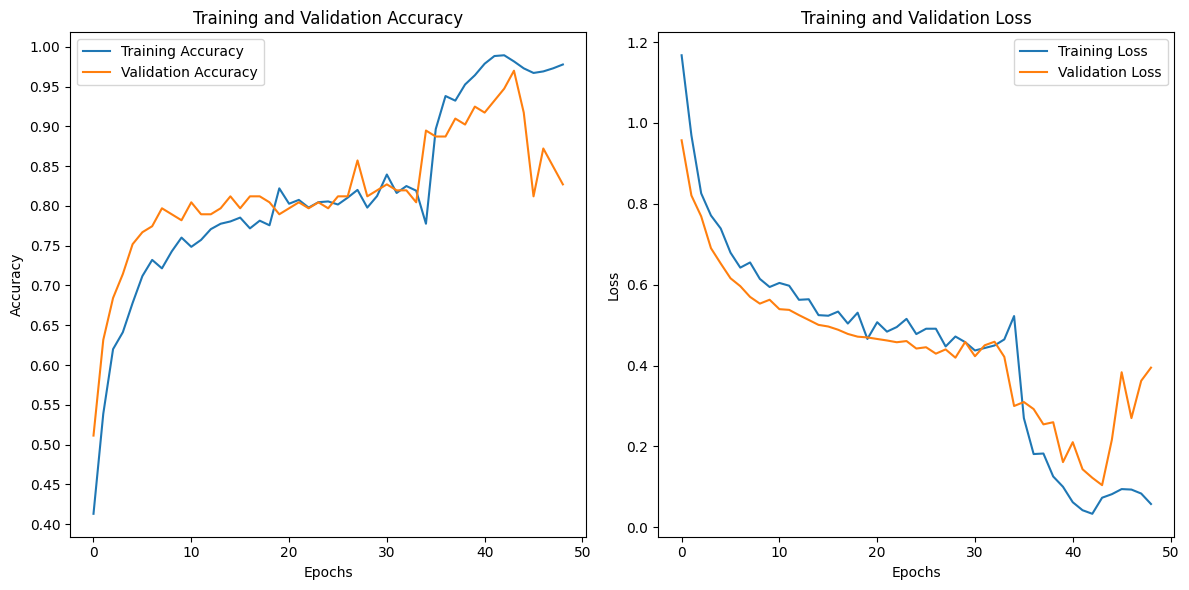

In [ ]:
plot_training_history(nadam_nasNet_history, nadam_nasNet_history_fine)

In [ ]:
with tf.device('/gpu:0'):
    nasNet_base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    rmsprop_nasNet_model, rmsprop_nasNet_history, rmsprop_nasNet_history_fine = train_model(base_model=
                                                                                      nasNet_base_model, 
                dense_layers=[256], dense_layers_dropout=[0.5], 
                train_generator=train_generator, validation_generator=validation_generator, 
                optimizer='rmsprop', loss='categorical_crossentropy', 
                metrics=['accuracy', Precision(), Recall()], freezed_epochs=100, fine_tune_epochs=100)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.4169 - loss: 1.2633 - precision_2: 0.4323 - recall_2: 0.3325 - val_accuracy: 0.5338 - val_loss: 0.8687 - val_precision_2: 0.6596 - val_recall_2: 0.4662
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 432ms/step - accuracy: 0.5737 - loss: 0.8977 - precision_2: 0.6184 - recall_2: 0.4599 - val_accuracy: 0.7594 - val_loss: 0.7194 - val_precision_2: 0.7778 - val_recall_2: 0.6316
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 434ms/step - accuracy: 0.6354 - loss: 0.8263 - precision_2: 0.6798 - recall_2: 0.5444 - val_accuracy: 0.7368 - val_loss: 0.6707 - val_precision_2: 0.8163 - val_recall_2: 0.6015
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 428ms/step - accuracy: 0.6741 - loss: 0.7239 - precision_2: 0.7363 - recall_2: 0.5987 - val_accuracy: 0.7368 - val_loss: 0.6536 - val_precision_2: 0.7864 - val_recall_2: 0.6090
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 428ms/step - accuracy: 0.6922 - loss: 0.6987 - precision_2: 0.7444 - recall_2: 0.6305 - va

In [ ]:
rmsprop_nasNet_test_loss, rmsprop_nasNet_test_accuracy, rmsprop_nasNet_test_precision, rmsprop_nasNet_test_recall = rmsprop_nasNet_model.evaluate(test_generator)
print(f"Test Accuracy: {rmsprop_nasNet_test_accuracy * 100:.2f}% \nTest recall: {rmsprop_nasNet_test_recall * 100:.2f}% \nTest precision: {rmsprop_nasNet_test_precision * 100:.2f}% \n ")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step - accuracy: 0.8490 - loss: 0.4170 - precision_2: 0.8717 - recall_2: 0.8490
Test Accuracy: 85.16% 
Test recall: 85.16% 
Test precision: 87.20% 
 


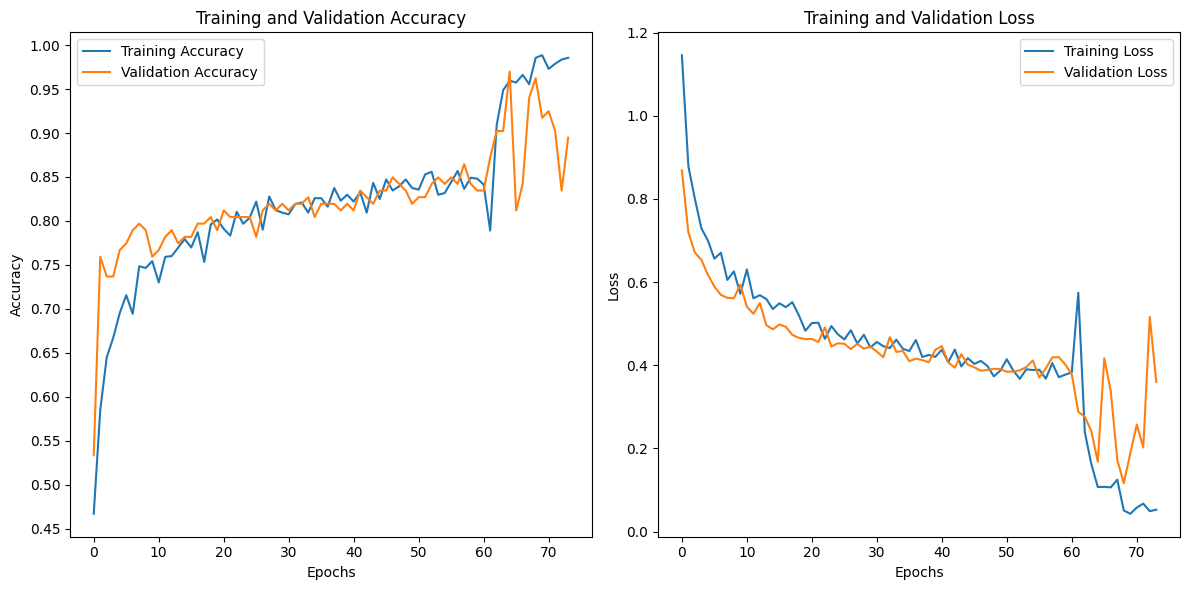

In [ ]:
plot_training_history(rmsprop_nasNet_history, rmsprop_nasNet_history_fine)

In [ ]:
with tf.device('/gpu:0'):
    EfficientNet_base_model = EfficientNetB6(weights='imagenet', include_top=False, 
                                             input_shape=(224, 224, 3))
    rmsprop_EfficientNet_model, rmsprop_EfficientNet_history, rmsprop_EfficientNet_history_fine = train_model(base_model=
                                                                                      EfficientNet_base_model, 
                dense_layers=[256], dense_layers_dropout=[0.5], 
                train_generator=no_scale_train_generator, validation_generator=no_scale_validation_generator, 
                optimizer='rmsprop', loss='categorical_crossentropy', 
                metrics=['accuracy', Precision(), Recall()], freezed_epochs=100, fine_tune_epochs=100)


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 198s 6s/step - accuracy: 0.5311 - loss: 0.9556 - precision_1: 0.6798 - recall_1: 0.3113 - val_accuracy: 0.6842 - val_loss: 0.7314 - val_precision_1: 0.7757 - val_recall_1: 0.6241
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 582ms/step - accuracy: 0.7392 - loss: 0.6600 - precision_1: 0.8072 - recall_1: 0.6154 - val_accuracy: 0.7820 - val_loss: 0.5732 - val_precision_1: 0.8571 - val_recall_1: 0.7218
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 581ms/step - accuracy: 0.7664 - loss: 0.5620 - precision_1: 0.8185 - recall_1: 0.7064 - val_accuracy: 0.7895 - val_loss: 0.5371 - val_precision_1: 0.8319 - val_recall_1: 0.7444
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 571ms/step - accuracy: 0.8112 - loss: 0.4963 - precision_1: 0.8481 - recall_1: 0.7754 - val_accuracy: 0.7970 - val_loss: 0.5243 - val_precision_1: 0.8319 - val_recall_1: 0.7444
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 634ms/step - accuracy: 0.8031 - loss: 0.4818 - precision_1: 0.8286 - recall_1: 

In [ ]:
rmsprop_EfficientNet_test_loss, rmsprop_EfficientNet_test_accuracy, rmsprop_EfficientNet_test_precision, rmsprop_EfficientNet_test_recall = rmsprop_EfficientNet_model.evaluate(no_scale_test_generator)
print(f"Test Accuracy: {rmsprop_EfficientNet_test_accuracy * 100:.2f}% \nTest recall: {rmsprop_EfficientNet_test_recall * 100:.2f}% \nTest precision: {rmsprop_EfficientNet_test_precision * 100:.2f}% \n ")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step - accuracy: 0.9375 - loss: 0.3374 - precision_1: 0.9375 - recall_1: 0.9375
Test Accuracy: 94.53% 
Test recall: 94.53% 
Test precision: 94.53% 
 


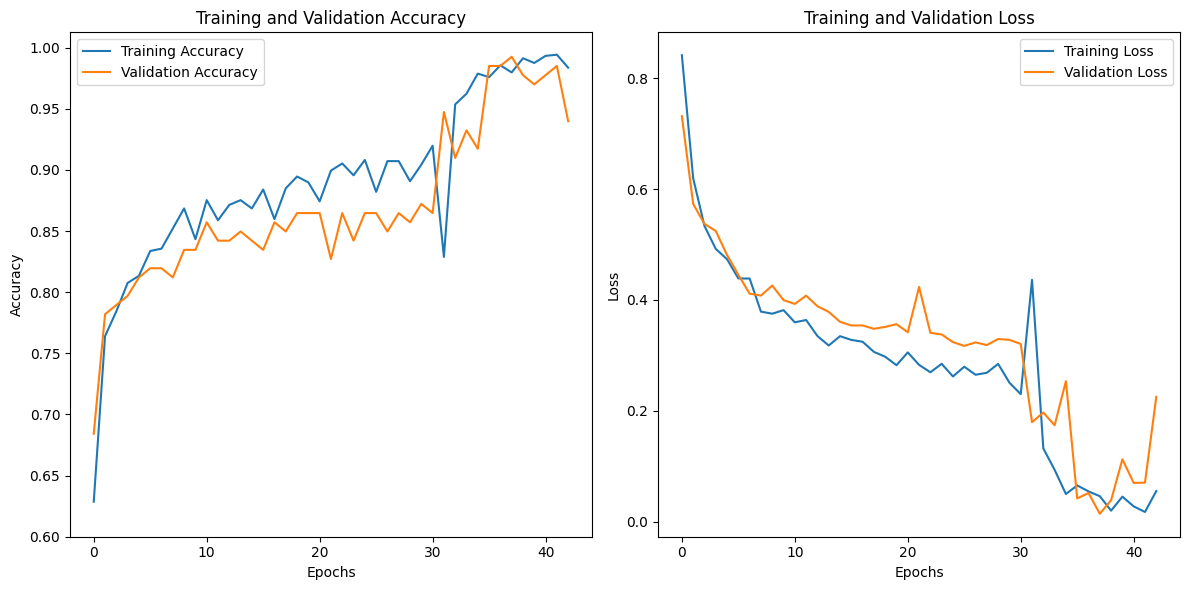

In [ ]:
plot_training_history(rmsprop_EfficientNet_history, rmsprop_EfficientNet_history_fine)

In [ ]:
with tf.device('/gpu:0'):
    EfficientNet_base_model = EfficientNetB6(weights='imagenet', include_top=False, 
                                             input_shape=(224, 224, 3))
    nadam_EfficientNet_model, nadam_EfficientNet_history, nadam_EfficientNet_history_fine = train_model(base_model=
                                                                                      EfficientNet_base_model, 
                dense_layers=[256], dense_layers_dropout=[0.5], 
                train_generator=no_scale_train_generator, validation_generator=no_scale_validation_generator, 
                optimizer='nadam', loss='categorical_crossentropy', 
                metrics=['accuracy', Precision(), Recall()], freezed_epochs=100, fine_tune_epochs=100)


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 186s 5s/step - accuracy: 0.5020 - loss: 1.0156 - precision_3: 0.5999 - recall_3: 0.1451 - val_accuracy: 0.7669 - val_loss: 0.7548 - val_precision_3: 0.9091 - val_recall_3: 0.4511
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 589ms/step - accuracy: 0.7545 - loss: 0.6990 - precision_3: 0.8222 - recall_3: 0.5866 - val_accuracy: 0.7895 - val_loss: 0.5829 - val_precision_3: 0.8532 - val_recall_3: 0.6992
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 636ms/step - accuracy: 0.7834 - loss: 0.5696 - precision_3: 0.8308 - recall_3: 0.7025 - val_accuracy: 0.7744 - val_loss: 0.5367 - val_precision_3: 0.8115 - val_recall_3: 0.7444
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 605ms/step - accuracy: 0.7860 - loss: 0.5456 - precision_3: 0.8184 - recall_3: 0.7323 - val_accuracy: 0.8045 - val_loss: 0.5036 - val_precision_3: 0.8475 - val_recall_3: 0.7519
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 597ms/step - accuracy: 0.8052 - loss: 0.4912 - precision_3: 0.8336 - recall_3: 

In [ ]:
nadam_EfficientNet_test_loss, nadam_EfficientNet_test_accuracy, nadam_EfficientNet_test_precision, nadam_EfficientNet_test_recall = nadam_EfficientNet_model.evaluate(no_scale_test_generator)
print(f"Test Accuracy: {nadam_EfficientNet_test_accuracy * 100:.2f}% \nTest recall: {nadam_EfficientNet_test_recall * 100:.2f}% \nTest precision: {nadam_EfficientNet_test_precision * 100:.2f}% \n ")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step - accuracy: 0.9531 - loss: 0.2398 - precision_3: 0.9531 - recall_3: 0.9531
Test Accuracy: 94.53% 
Test recall: 94.53% 
Test precision: 94.53% 
 


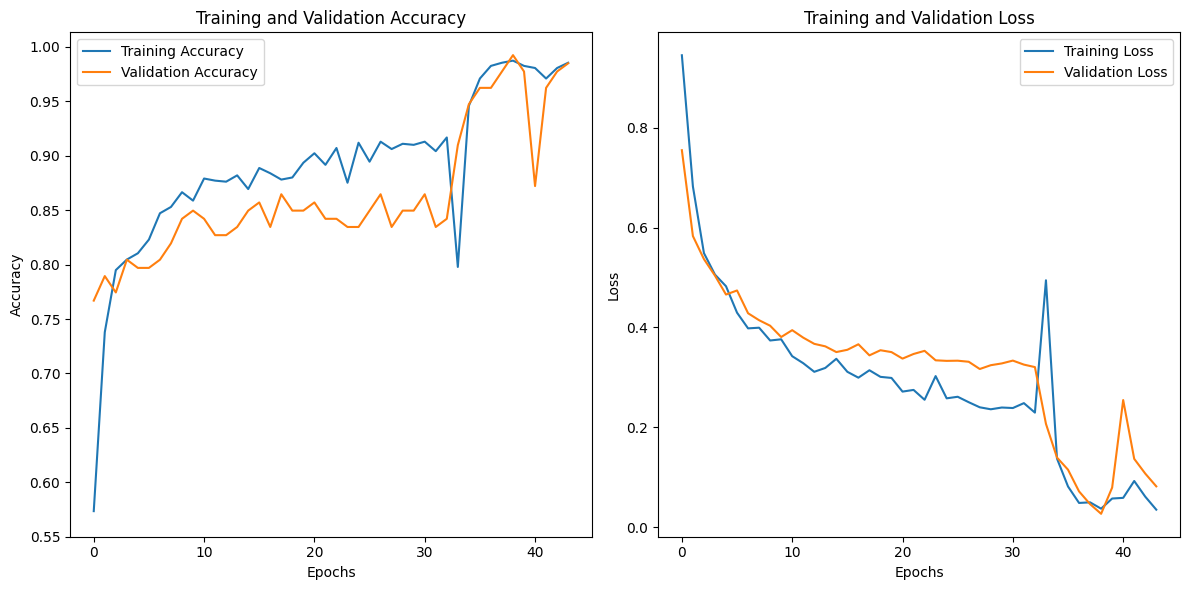

In [ ]:
plot_training_history(nadam_EfficientNet_history, nadam_EfficientNet_history_fine)

In [ ]:
with tf.device('/gpu:0'):
    EfficientNet_base_model = EfficientNetB6(weights='imagenet', include_top=False, 
                                             input_shape=(224, 224, 3))
    adam_EfficientNet_model, adam_EfficientNet_history, adam_EfficientNet_history_fine = train_model(base_model=
                                                                                      EfficientNet_base_model, 
                dense_layers=[256], dense_layers_dropout=[0.5], 
                train_generator=no_scale_train_generator, validation_generator=no_scale_validation_generator, 
                optimizer='adam', loss='categorical_crossentropy', 
                metrics=['accuracy', Precision(), Recall()], freezed_epochs=100, fine_tune_epochs=100)


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 196s 6s/step - accuracy: 0.4939 - loss: 1.0296 - precision_4: 0.5868 - recall_4: 0.1842 - val_accuracy: 0.7218 - val_loss: 0.7640 - val_precision_4: 0.8049 - val_recall_4: 0.4962
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 594ms/step - accuracy: 0.7208 - loss: 0.6800 - precision_4: 0.8021 - recall_4: 0.5986 - val_accuracy: 0.7820 - val_loss: 0.6014 - val_precision_4: 0.8261 - val_recall_4: 0.7143
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 652ms/step - accuracy: 0.7684 - loss: 0.5591 - precision_4: 0.8145 - recall_4: 0.7155 - val_accuracy: 0.8120 - val_loss: 0.5489 - val_precision_4: 0.8547 - val_recall_4: 0.7519
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 639ms/step - accuracy: 0.8147 - loss: 0.4896 - precision_4: 0.8451 - recall_4: 0.7671 - val_accuracy: 0.8045 - val_loss: 0.5255 - val_precision_4: 0.8235 - val_recall_4: 0.7368
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 664ms/step - accuracy: 0.8254 - loss: 0.4648 - precision_4: 0.8532 - recall_4: 

I0000 00:00:1732384875.236647      74 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_20', 24 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_19', 64 bytes spill stores, 64 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_18', 232 bytes spill stores, 236 bytes spill loads



17/17 ━━━━━━━━━━━━━━━━━━━━ 500s 13s/step - accuracy: 0.7473 - loss: 0.6213 - precision_4: 0.8102 - recall_4: 0.7720 - val_accuracy: 0.9173 - val_loss: 0.2044 - val_precision_4: 0.9173 - val_recall_4: 0.9173
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8992 - loss: 0.2513 - precision_4: 0.9028 - recall_4: 0.8962 - val_accuracy: 0.9248 - val_loss: 0.2056 - val_precision_4: 0.9318 - val_recall_4: 0.9248
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9739 - loss: 0.1033 - precision_4: 0.9743 - recall_4: 0.9739 - val_accuracy: 0.9323 - val_loss: 0.1521 - val_precision_4: 0.9323 - val_recall_4: 0.9323
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9691 - loss: 0.0843 - precision_4: 0.9691 - recall_4: 0.9691 - val_accuracy: 0.9699 - val_loss: 0.0962 - val_precision_4: 0.9699 - val_recall_4: 0.9699
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 23s 995ms/step - accuracy: 0.9774 - loss: 0.0676 - precision_4: 0.9774 - recall_4: 0.9774 - val_accurac

In [ ]:
adam_EfficientNet_test_loss, adam_EfficientNet_test_accuracy, adam_EfficientNet_test_precision, adam_EfficientNet_test_recall = adam_EfficientNet_model.evaluate(no_scale_test_generator)
print(f"Test Accuracy: {adam_EfficientNet_test_accuracy * 100:.2f}% \nTest recall: {adam_EfficientNet_test_recall * 100:.2f}% \nTest precision: {adam_EfficientNet_test_precision * 100:.2f}% \n ")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - accuracy: 0.9479 - loss: 0.5494 - precision_4: 0.9479 - recall_4: 0.9479
Test Accuracy: 96.09% 
Test recall: 96.09% 
Test precision: 96.09% 
 


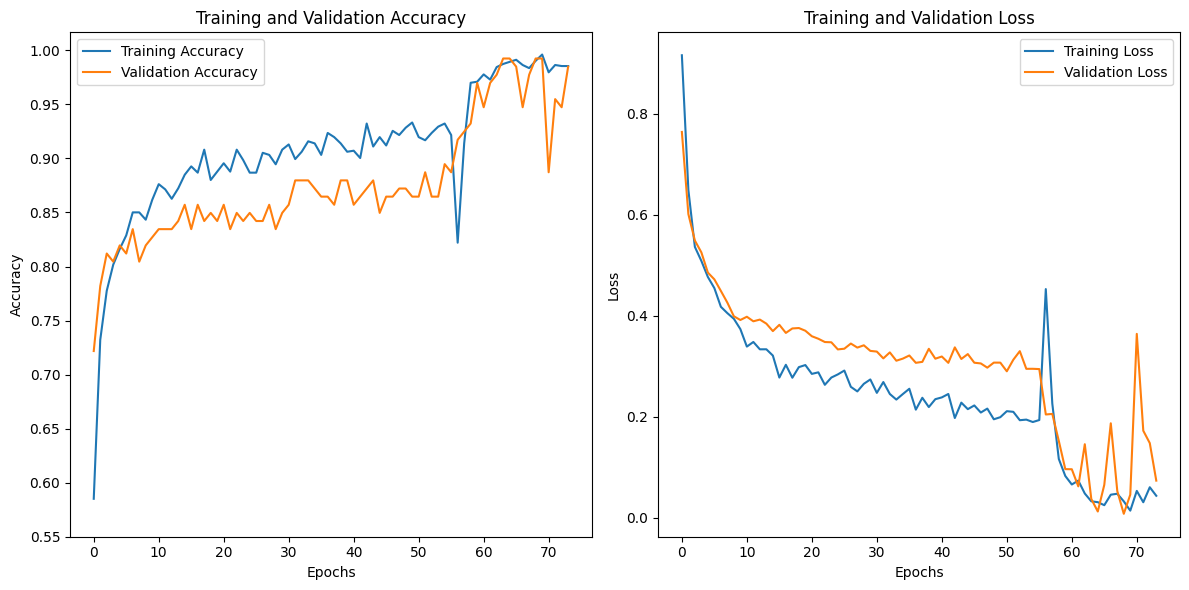

In [ ]:
plot_training_history(adam_EfficientNet_history, adam_EfficientNet_history_fine)

In [ ]:
with tf.device('/gpu:0'):
    MobileNetV2_base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3), alpha=1.4)
    adam_MobileNetV2_model, adam_MobileNetV2_history, adam_MobileNetV2_history_fine = train_model2(base_model=
                                                                                      MobileNetV2_base_model, 
                dense_layers=[256], dense_layers_dropout=[0.5], 
                train_generator=train_generator, validation_generator=validation_generator, 
                optimizer='adam', loss='categorical_crossentropy', 
                metrics=['accuracy', Precision(), Recall()], freezed_epochs=100, fine_tune_epochs=100)


17831080/17831080 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732368714.188060      76 service.cc:145] XLA service 0x7f09f00049d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732368714.188117      76 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


2/9 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.3301 - loss: 1.3923 - precision: 0.3335 - recall: 0.2324

I0000 00:00:1732368723.891368      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.4037 - loss: 1.2320 - precision: 0.4305 - recall: 0.3087 - val_accuracy: 0.7594 - val_loss: 0.6322 - val_precision: 0.7768 - val_recall: 0.6541
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 391ms/step - accuracy: 0.6729 - loss: 0.6946 - precision: 0.7199 - recall: 0.6108 - val_accuracy: 0.7820 - val_loss: 0.5149 - val_precision: 0.8305 - val_recall: 0.7368
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - accuracy: 0.7711 - loss: 0.5662 - precision: 0.7990 - recall: 0.7246 - val_accuracy: 0.8647 - val_loss: 0.3980 - val_precision: 0.8800 - val_recall: 0.8271
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 381ms/step - accuracy: 0.8052 - loss: 0.4776 - precision: 0.8238 - recall: 0.7769 - val_accuracy: 0.8722 - val_loss: 0.3714 - val_precision: 0.8889 - val_recall: 0.8421
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 372ms/step - accuracy: 0.8109 - loss: 0.4528 - precision: 0.8389 - recall: 0.7915 - val_accuracy: 0.8271 - val_loss: 0.3905 - val_prec

In [ ]:
adam_MobileNetV2_test_loss, adam_MobileNetV2_test_accuracy, adam_MobileNetV2_test_precision, adam_MobileNetV2_test_recall = adam_MobileNetV2_model.evaluate(test_generator)
print(f"Test Accuracy: {adam_MobileNetV2_test_accuracy * 100:.2f}% \nTest recall: {adam_MobileNetV2_test_recall * 100:.2f}% \nTest precision: {adam_MobileNetV2_test_precision * 100:.2f}% \n ")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - accuracy: 0.9062 - loss: 0.5242 - precision: 0.9062 - recall: 0.9062
Test Accuracy: 91.41% 
Test recall: 91.41% 
Test precision: 91.41% 
 


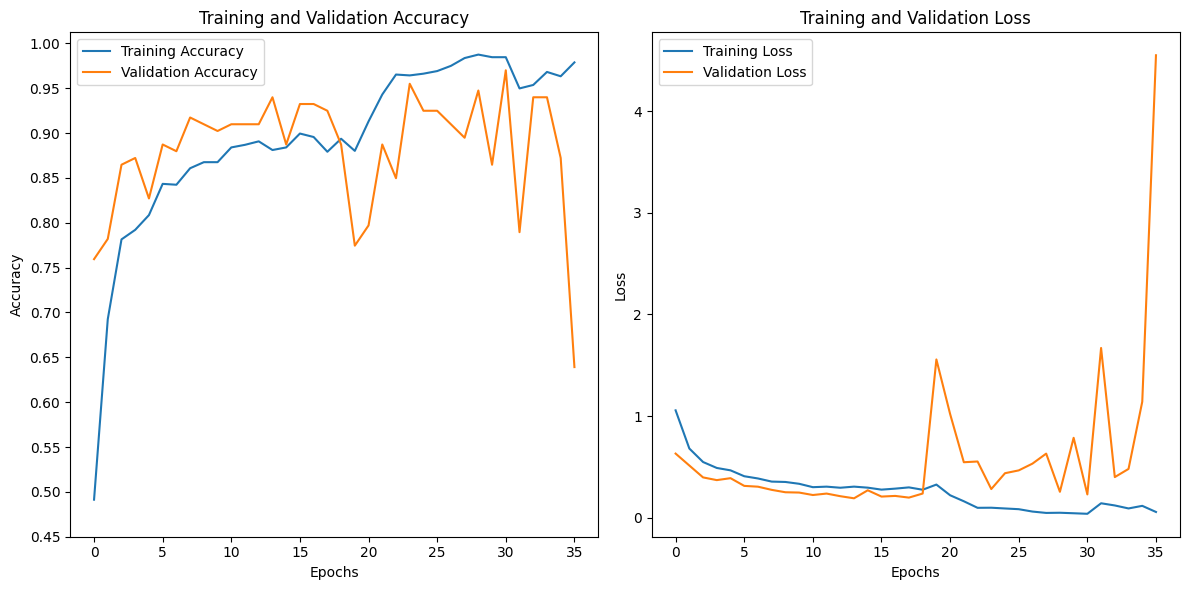

In [ ]:
plot_training_history(adam_MobileNetV2_history, adam_MobileNetV2_history_fine)

In [ ]:
with tf.device('/gpu:0'):
    MobileNetV2_base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3), alpha=1.4)
    nadam_MobileNetV2_model, nadam_MobileNetV2_history, nadam_MobileNetV2_history_fine = train_model2(base_model=
                                                                                      MobileNetV2_base_model, 
                dense_layers=[256], dense_layers_dropout=[0.5], 
                train_generator=train_generator, validation_generator=validation_generator, 
                optimizer='nadam', loss='categorical_crossentropy', 
                metrics=['accuracy', Precision(), Recall()], freezed_epochs=100, fine_tune_epochs=100)


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 994ms/step - accuracy: 0.4104 - loss: 1.4104 - precision_2: 0.4228 - recall_2: 0.3364 - val_accuracy: 0.6617 - val_loss: 0.8002 - val_precision_2: 0.7442 - val_recall_2: 0.4812
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 379ms/step - accuracy: 0.6047 - loss: 0.8492 - precision_2: 0.6562 - recall_2: 0.5307 - val_accuracy: 0.7895 - val_loss: 0.5941 - val_precision_2: 0.8547 - val_recall_2: 0.7519
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 400ms/step - accuracy: 0.7265 - loss: 0.6122 - precision_2: 0.7559 - recall_2: 0.6809 - val_accuracy: 0.8346 - val_loss: 0.4735 - val_precision_2: 0.8824 - val_recall_2: 0.7895
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 384ms/step - accuracy: 0.7679 - loss: 0.5375 - precision_2: 0.7996 - recall_2: 0.7267 - val_accuracy: 0.8571 - val_loss: 0.3935 - val_precision_2: 0.8871 - val_recall_2: 0.8271
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 386ms/step - accuracy: 0.7898 - loss: 0.4907 - precision_2: 0.8170 - recall_2: 0.7551 -

In [ ]:
nadam_MobileNetV2_test_loss, nadam_MobileNetV2_test_accuracy, nadam_MobileNetV2_test_precision, nadam_MobileNetV2_test_recall = nadam_MobileNetV2_model.evaluate(test_generator)
print(f"Test Accuracy: {nadam_MobileNetV2_test_accuracy * 100:.2f}% \nTest recall: {nadam_MobileNetV2_test_recall * 100:.2f}% \nTest precision: {nadam_MobileNetV2_test_precision * 100:.2f}% \n ")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step - accuracy: 0.9167 - loss: 0.2440 - precision_2: 0.9167 - recall_2: 0.9167
Test Accuracy: 92.19% 
Test recall: 92.19% 
Test precision: 92.19% 
 


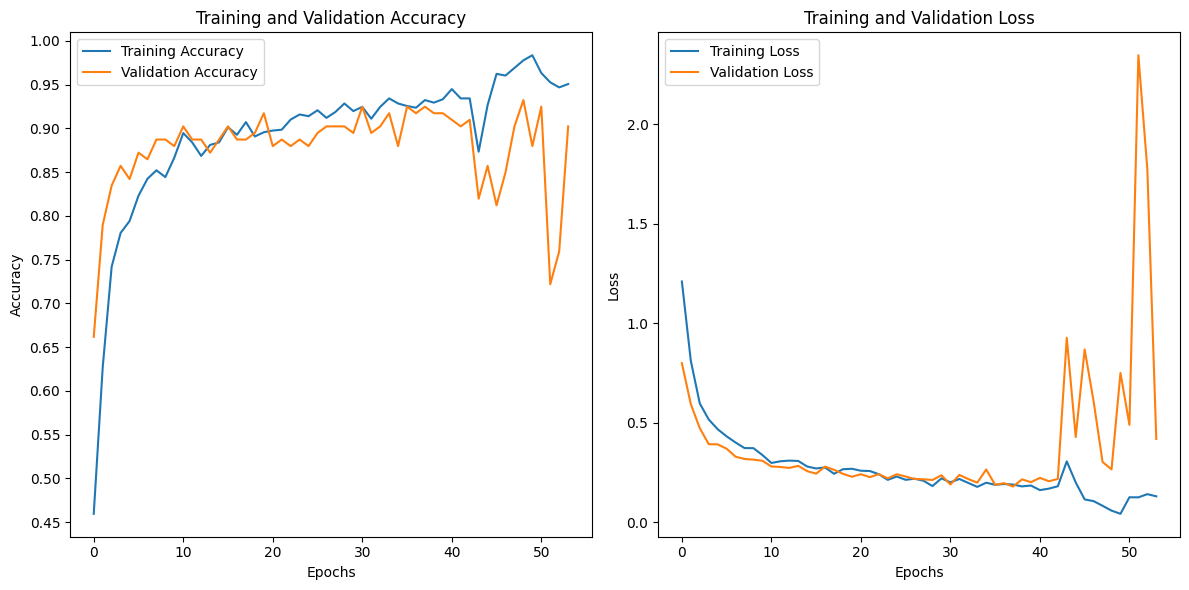

In [ ]:
plot_training_history(nadam_MobileNetV2_history, nadam_MobileNetV2_history_fine)

In [ ]:
with tf.device('/gpu:0'):
    MobileNetV2_base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3), alpha=1.4)
    rmsprop_MobileNetV2_model, rmsprop_MobileNetV2_history, rmsprop_MobileNetV2_history_fine = train_model2(base_model=
                                                                                      MobileNetV2_base_model, 
                dense_layers=[128], dense_layers_dropout=[0.5], 
                train_generator=train_generator, validation_generator=validation_generator, 
                optimizer='rmsprop', loss='categorical_crossentropy', 
                metrics=['accuracy', Precision(), Recall()], freezed_epochs=100, fine_tune_epochs=100,learning_rate=3e-4)


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4347 - loss: 1.4314 - precision_3: 0.4571 - recall_3: 0.3891 - val_accuracy: 0.7519 - val_loss: 0.6639 - val_precision_3: 0.8526 - val_recall_3: 0.6090
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 402ms/step - accuracy: 0.6794 - loss: 0.7265 - precision_3: 0.7278 - recall_3: 0.5919 - val_accuracy: 0.7669 - val_loss: 0.5544 - val_precision_3: 0.8476 - val_recall_3: 0.6692
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 398ms/step - accuracy: 0.7201 - loss: 0.6566 - precision_3: 0.7656 - recall_3: 0.6551 - val_accuracy: 0.8120 - val_loss: 0.4961 - val_precision_3: 0.8667 - val_recall_3: 0.7820
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 383ms/step - accuracy: 0.7678 - loss: 0.5733 - precision_3: 0.7972 - recall_3: 0.7116 - val_accuracy: 0.8797 - val_loss: 0.4145 - val_precision_3: 0.9244 - val_recall_3: 0.8271
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 199ms/step - accuracy: 0.7721 - loss: 0.5681 - precision_3: 0.8000 - recall_3: 0.7197 - va

In [ ]:
rmsprop_MobileNetV2_test_loss, rmsprop_MobileNetV2_test_accuracy, rmsprop_MobileNetV2_test_precision, rmsprop_MobileNetV2_test_recall = rmsprop_MobileNetV2_model.evaluate(test_generator)
print(f"Test Accuracy: {rmsprop_MobileNetV2_test_accuracy * 100:.2f}% \nTest recall: {rmsprop_MobileNetV2_test_recall * 100:.2f}% \nTest precision: {rmsprop_MobileNetV2_test_precision * 100:.2f}% \n ")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step - accuracy: 0.9167 - loss: 0.2181 - precision_3: 0.9158 - recall_3: 0.9062
Test Accuracy: 92.19% 
Test recall: 91.41% 
Test precision: 92.13% 
 


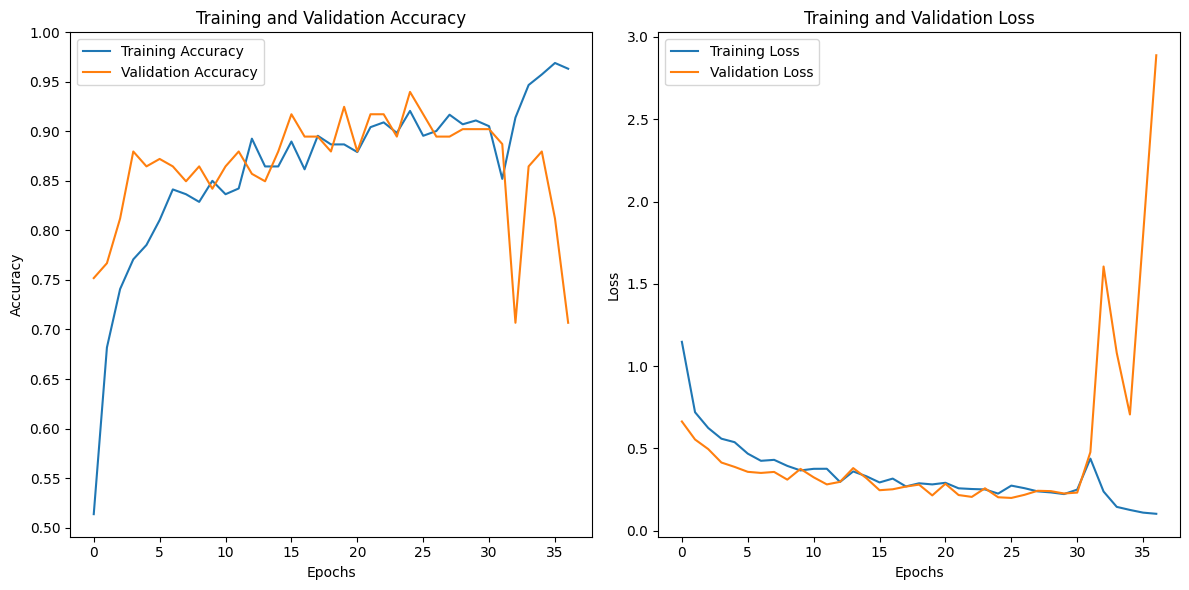

In [ ]:
plot_training_history(rmsprop_MobileNetV2_history, rmsprop_MobileNetV2_history_fine)